In [1]:
import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI')

import numpy as np
from src.RL_functions.generate_one_synthetic_time_series import generate_one_synthetic_time_series
from scipy.stats import multivariate_normal
from src.RL_functions.actor_critic_kf import *
from tqdm import tqdm
from src.RL_functions.helpers import get_look_back_time_steps, hidden_states_collector

### Time series generation

In [2]:
# Time series config
components = ['level','ar']
time_step_interval = 1

AR_param_var = 5**2
AR_param_phi = 0.9
hyperparameters = {'level': {'process_error_var': 0.0},
                #    'fourrier': {'period': 52, 'process_error_var': 0},
                   'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                   'observation': {'error': 1e-6}}
x_init = {'mu': np.array([5, -0.0621]), \
          'var': np.diag([0.00531, 6.36E-05])}
# x_init = {'mu': np.array([5, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
#           'var': np.diag([0.00531,1e-12, 1e-12, 6.36E-05])}
num_steps = 400
num_ts = 1000


In [3]:
# # Compute anomaly magnitude: proportional to the stationary variance of AR process
# AR_stationary_var = hyperparameters['ar']['process_error_var'] / (1 - hyperparameters['ar']['phi']**2)

# # Create a dictionary storing the data_generator.time_series['timesteps'], data_generator.time_series['y'], and anm_mag
# data = {'timesteps': [], 'y': [], 'anm_mag': [], 'anm_pos': []}

# # Generate time series
# for ts_n in tqdm(range(num_ts)):
#     np.random.seed(ts_n)

#     # Changed the AR each time
#     data_generator = generate_one_synthetic_time_series(components = components, 
#                                                         time_step_interval = time_step_interval, 
#                                                         hyperparameters = hyperparameters, 
#                                                         num_steps = num_steps,
#                                                         x_init = x_init)

#     # Periodic patten is fixed
#     components_P = ['level','fourrier']
#     hyperparameters_P = {'level': {'process_error_var': 0.0},
#                     'fourrier': {'period': 52, 'process_error_var': 0},
#                     'observation': {'error': 0}}
#     x_init_P = {'mu': np.array([0, np.sqrt(AR_param_var) * 5, 0]), \
#             'var': np.diag([0, 1e-12, 1e-12])}
#     data_generator_P = generate_one_synthetic_time_series(components = components_P, 
#                                                         time_step_interval = time_step_interval, 
#                                                         hyperparameters = hyperparameters_P, 
#                                                         num_steps = num_steps,
#                                                         x_init = x_init_P)

#     data_generator.time_series['y'] = (np.array(data_generator.time_series['y']) + np.array(data_generator_P.time_series['y'])).tolist()

#     # Add anomaly
#     anm_pos = 200
#     anm_mag = - (np.sqrt(AR_stationary_var)*1) / 50
#     for i in range(num_steps):
#         if i >= anm_pos:
#             data_generator.time_series['y'][i] += anm_mag * (i - anm_pos)
#     # data_generator.plot()
    
#     data['y'].append(data_generator.time_series['y'])
#     data['anm_mag'].append(anm_mag)
#     data['anm_pos'].append(anm_pos)

#     # Store timesteps only once since they are the same for all time series
#     if ts_n == 0:
#         data['timesteps'].append(data_generator.time_series['timesteps'])
#     else:
#         data['timesteps'].append([])

# # Save data as float number to 1 csv using pandas
# import pandas as pd
# data = pd.DataFrame(data)
# data.to_csv('data/hsl_synthetic_time_series.csv', index=False)


### Analyze time series

In [4]:
# Load time series, data as float
import pandas as pd
data = pd.read_csv('data/hsl_synthetic_time_series_rand_anmmag.csv')
data['y'] = data['y'].apply(lambda x: list(map(float, x[1:-1].split(','))))
# Convert data['timesteps'][0] from list of str to list of float
data['timesteps'][0] = list(map(float, data['timesteps'][0][1:-1].split(',')))
data['anm_mag'] = data['anm_mag'].apply(lambda x: float(x))
data['anm_pos'] = data['anm_pos'].apply(lambda x: int(x))

/var/folders/vv/62ff9wx97g72zr4_20vx1q3h0000gn/T/ipykernel_97698/1472982120.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['timesteps'][0] = list(map(float, data['timesteps'][0][1:-1].split(',')))


In [5]:
# # Config for the base and drift models
components = ['trend','fourrier', 'ar']
components_d = ['trend', 'ar']

hyperparameters = {'trend': {'process_error_var': 0},
                    'fourrier': {'period': 52, 'process_error_var': 0},
                    'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                    'observation': {'error': 1e-6}}
hyperparameters_d = {'trend': {'process_error_var': 0, 'phi': 1},
                    'ar': {'phi': AR_param_phi, 'process_error_var': AR_param_var},
                    'observation': {'error': 1e-6}}

x_init = {'mu': np.array([5, 0, np.sqrt(AR_param_var) * 5, 0, -0.0621]), \
            'var': np.diag([1e-12, 1E-12, 1e-12, 1E-12, 6.36E-05])}
x_init_d = {'mu': np.array([0, 0.0, -0.0621]), \
            'var': np.diag([1e-12, 1e-12, 6.36E-05])}

baseline_process_error_var_all = [1e-6]

In [6]:
# kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)
# x_samples_mean_all, x_samples_cov_all = [], []
# for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
#     hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
#     kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
#     x_samples_mean, x_samples_cov = estimate_hs_distribution(components, time_step_interval, hyperparameters, num_steps, x_init, x_init_d, kf, kf_d)
#     x_samples_mean_all.append(x_samples_mean)
#     x_samples_cov_all.append(x_samples_cov)
#     print(x_samples_mean, x_samples_cov)

# Hidden state distribution provided by users
x_samples_mean_all = [-0.00080167]
x_samples_cov_all = [2.0644215838756797e-05]

In [7]:
print(data['y'])

0      [38.58209456102765, 48.3659450112352, 50.30900...
1      [37.8835581425958, 31.16795315981634, 38.80443...
2      [27.6780404792279, 35.54918732260426, 36.53789...
3      [38.70497431610041, 27.9546086945063, 26.77465...
4      [30.014639392257116, 32.91876307467385, 28.417...
                             ...                        
995    [26.382728875142227, 22.73745727388584, 24.147...
996    [26.69869138652716, 27.910236554797212, 44.100...
997    [34.12413868519431, 33.43015233051527, 21.9855...
998    [30.3525060327348, 27.21838609182055, 30.22735...
999    [30.397621387214876, 25.50320826297191, 32.813...
Name: y, Length: 1000, dtype: object


In [8]:
# Analyze the time series using base and drift models
samples = {'LTd_history': [], 'itv_LT': [], 'itv_LL': [], 'anm_develop_time': []}

kf = KalmanFilter(components = components, time_step=time_step_interval, hyperparameters = hyperparameters)
prior_a = [0.998, 0.002]

ts_n = 4

x_likelihood_na_all = []
x_likelihood_a_all = []
y_likelihood_na_all = []
y_likelihood_a_all = []
trigger_pos = []

x_last_step = x_init
x_last_step_d = x_init_d

mv_normal_x_all = []
scale_factors_all = []

intervene = False
intervention_state = None
stop_collecting_samples = False

for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
    x_samples_mean, x_samples_cov = x_samples_mean_all[j], x_samples_cov_all[j]
    mv_normal_x = multivariate_normal(mean=x_samples_mean, cov=x_samples_cov, allow_singular=True)
    mv_normal_x_all.append(mv_normal_x)
    scale_factors_all.append(mv_normal_x.pdf(x_samples_mean))

p_na_I_Mj_Yt1 = prior_a[0]
p_a_I_Mj_Yt1 = prior_a[1]
p_Mj_I_Yt_all = []
p_a0_all = []
LL_mu, LT_mu, AR_mu, y_pred_mus = [], [], [], []
LL_var, LT_var, AR_var, y_pred_vars = [], [], [], []
# LTd_all = {'mu': [x_init_d['mu'][1]], 'var': [x_init_d['var'][1][1]]}
LTd_all = {'mu': [], 'var': []}
plot_model_index = 0
LLj_mu, LTj_mu, ARj_mu, yj_pred_mus, LLjd_mu, LTjd_mu, ARjd_mu, yjd_pred_mus = [], [], [], [], [], [], [], []
LLj_var, LTj_var, ARj_var, yj_pred_vars, LLjd_var, LTjd_var, ARjd_var, yjd_pred_vars  = [], [], [], [], [], [], [], []
for i in range(num_steps):
    xd_updated_remain_all = []
    x_y_likelihood = []
    for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
        hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
        kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
        x_last_step_d = x_init_d if i==0 else x_last_step_d_all[j]

        intervention_state = copy.deepcopy(x_last_step)
        intervention_state['mu'][0] += x_last_step_d['mu'][0]
        intervention_state['mu'][1] += x_last_step_d['mu'][1]
        intervention_state['var'][0,0] += x_last_step_d['var'][0,0]
        intervention_state['var'][1,1] += x_last_step_d['var'][1,1]
        intervention_state['mu'][-1] = x_last_step_d['mu'][-1]
        intervention_state['var'][-1,-1] = x_last_step_d['var'][-1,-1]

        if j==plot_model_index:
            y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na,\
                _, xd_updated_remain, _, _, x_pred, xd_pred, _, yj_pred, _, ar_pred = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data['y'][ts_n][i], mv_normal_x_all[j])
        else:
            y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na,\
                _, xd_updated_remain, _, _, _, xd_pred, _, _, _, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data['y'][ts_n][i], mv_normal_x_all[j])
        x_likelihood_a *= 1/scale_factors_all[j]
        x_likelihood_na *= 1/scale_factors_all[j]

        x_y_likelihood.append([x_likelihood_na.item(), x_likelihood_a.item(), y_likelihood_na.item(), y_likelihood_a.item()])
        xd_updated_remain_all.append(xd_updated_remain)

    x_y_likelihood_array = np.array(x_y_likelihood)
    p_yt_I_Mj_Yt1 = x_y_likelihood_array[:, 2] * x_y_likelihood_array[:, 0] * p_na_I_Mj_Yt1 + x_y_likelihood_array[:, 3] * x_y_likelihood_array[:, 1] * p_a_I_Mj_Yt1
    p_na_I_Mj_Yt = x_y_likelihood_array[:, 2] * x_y_likelihood_array[:, 0] * p_na_I_Mj_Yt1 / p_yt_I_Mj_Yt1
    p_a_I_Mj_Yt = x_y_likelihood_array[:, 3] * x_y_likelihood_array[:, 1] * p_a_I_Mj_Yt1 / p_yt_I_Mj_Yt1

    # Compute probability of taking intervention or not
    p_Mj_I_Yt = p_yt_I_Mj_Yt1 / np.sum(p_yt_I_Mj_Yt1)   # Probability of each model
    p_a0 = np.sum(p_na_I_Mj_Yt * p_Mj_I_Yt)             # Probability of not requiring intervention by all models

    p_Mj_I_Yt_all.append(p_Mj_I_Yt.tolist())
    p_a0_all.append(p_a0)

    if i > data['anm_pos'][ts_n] and stop_collecting_samples is not True:
        # Look back history for LTd
        LTd_history = hidden_states_collector(i - 1, LTd_all)
        samples['LTd_history'].append(LTd_history['mu'].tolist())
        samples['itv_LT'].append(data['anm_mag'][ts_n])
        anm_develop_time = i - 1 - data['anm_pos'][ts_n]
        samples['anm_develop_time'].append(anm_develop_time)
        samples['itv_LL'].append(data['anm_mag'][ts_n] * anm_develop_time)

    if p_a0 <= 0.5:
        print(i)
        look_back_idx_list = get_look_back_time_steps(i -1)
        ltd_history_sample = samples['LTd_history'][-1]

        intervene = True
        stop_collecting_samples = True
        trigger_pos.append(i)
        intervention_state = copy.deepcopy(x_init)
        intervention_state['mu'][1] = x_init['mu'][1] + samples['itv_LT'][-1]
        intervention_state['mu'][0] = x_init['mu'][0] + samples['itv_LL'][-1]
        intervention_state['mu'][2] = x_last_step['mu'][2]
        intervention_state['mu'][3] = x_last_step['mu'][3]

        # Update the critic models based on the actual intervention taken
        xd_updated_intervene_all = []
        x_y_likelihood = []
        for j, baseline_process_error_var in enumerate(baseline_process_error_var_all):
            hyperparameters_d['trend']['process_error_var'] = baseline_process_error_var
            kf_d = KalmanFilter(components = components_d, time_step=time_step_interval, hyperparameters = hyperparameters_d)
            x_last_step_d = x_init_d if i==0 else x_last_step_d_all[j]

            if j==plot_model_index:
                y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na, xd_updated_intervene, _, x_pred, xd_pred, _, _, yj_pred, _, ar_pred, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data['y'][0][i], mv_normal_x_all[j])
            else:
                y_likelihood_a, y_likelihood_na, x_likelihood_a, x_likelihood_na, xd_updated_intervene, _, _, xd_pred, _, _, _, _, _, _ = critic(kf, kf_d, x_last_step, x_last_step_d, intervention_state, x_init_d, data['y'][0][i], mv_normal_x_all[j])
            x_y_likelihood.append([x_likelihood_na.item(), x_likelihood_a.item(), y_likelihood_na.item(), y_likelihood_a.item()])
            xd_updated_intervene_all.append(xd_updated_intervene)
    else:
        intervene = False

    x_pred, y_pred, x_last_step = actor(kf, x_last_step, intervene, intervention_state, data['y'][ts_n][i])

    # Store all LTd for history collection
    LTd_all['mu'].append(xd_pred['mu'][1])
    LTd_all['var'].append(xd_pred['var'][1,1])

    LL_mu.append(x_pred['mu'][0])
    LT_mu.append(x_pred['mu'][1])
    AR_mu.append(x_pred['mu'][-1])
    LL_var.append(x_pred['var'][0,0])
    LT_var.append(x_pred['var'][1,1])
    AR_var.append(x_pred['var'][-1,-1])
    y_pred_mus.append(y_pred['mu'].item())
    y_pred_vars.append(y_pred['var'].item())

    LLj_mu.append(x_pred['mu'][0])
    LTj_mu.append(x_pred['mu'][1])
    ARj_mu.append(x_pred['mu'][-1])
    LLj_var.append(x_pred['var'][0,0])
    LTj_var.append(x_pred['var'][1,1])
    ARj_var.append(x_pred['var'][-1,-1])
    LLjd_mu.append(xd_pred['mu'][0])
    LTjd_mu.append(xd_pred['mu'][1])
    ARjd_mu.append(xd_pred['mu'][-1])
    LLjd_var.append(xd_pred['var'][0,0])
    LTjd_var.append(xd_pred['var'][1,1])
    ARjd_var.append(xd_pred['var'][-1,-1])
    yj_pred_mus.append(yj_pred['mu'].item())
    yj_pred_vars.append(yj_pred['var'].item())
    yjd_pred_mus.append(ar_pred['mu'])
    yjd_pred_vars.append(ar_pred['var'])

    x_last_step_d_all = xd_updated_intervene_all if intervene else xd_updated_remain_all


271


(-19.950000000000003, 418.95)

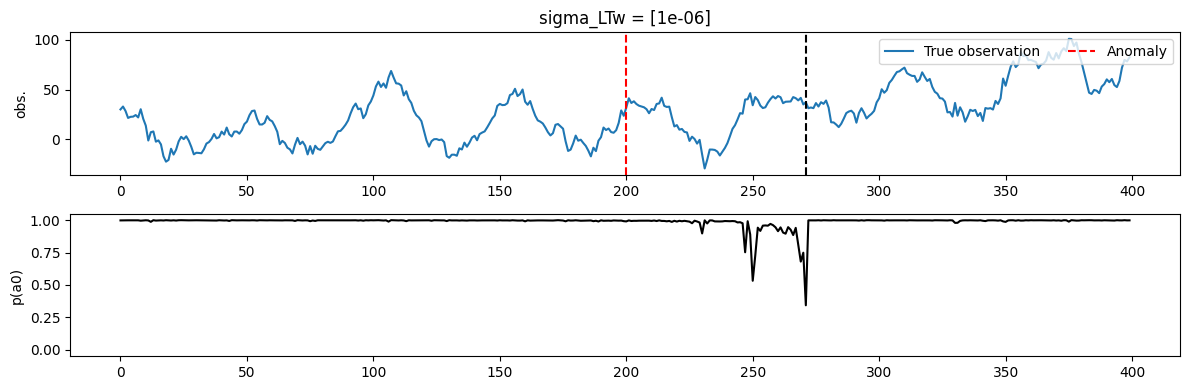

In [9]:
# Plot prediction
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 4))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

############ Base model ############
ax0.plot(data['timesteps'][0], data['y'][ts_n], label='True observation')
if data['anm_mag'][ts_n] != 0:
    ax0.axvline(x=data['anm_pos'][ts_n], color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) != 0:
    for pos in trigger_pos:
        ax0.axvline(x=pos, color='k', linestyle='--')
ax0.legend(loc='upper right', ncol = 2)
ax0.set_ylabel('obs.')
ax0.set_title('sigma_LTw = ' + str(baseline_process_error_var_all))
# ax0.set_title('sigma_LTw = 0.001')

ax1.plot(data['timesteps'][0], p_a0_all, 'k', label='p(a0)')
ax1.set_ylabel('p(a0)')
ax1.set_ylim([-0.05, 1.05])
# Set xlim as the same as ax0
ax1.set_xlim(ax0.get_xlim())

Text(0, 0.5, 'ARd')

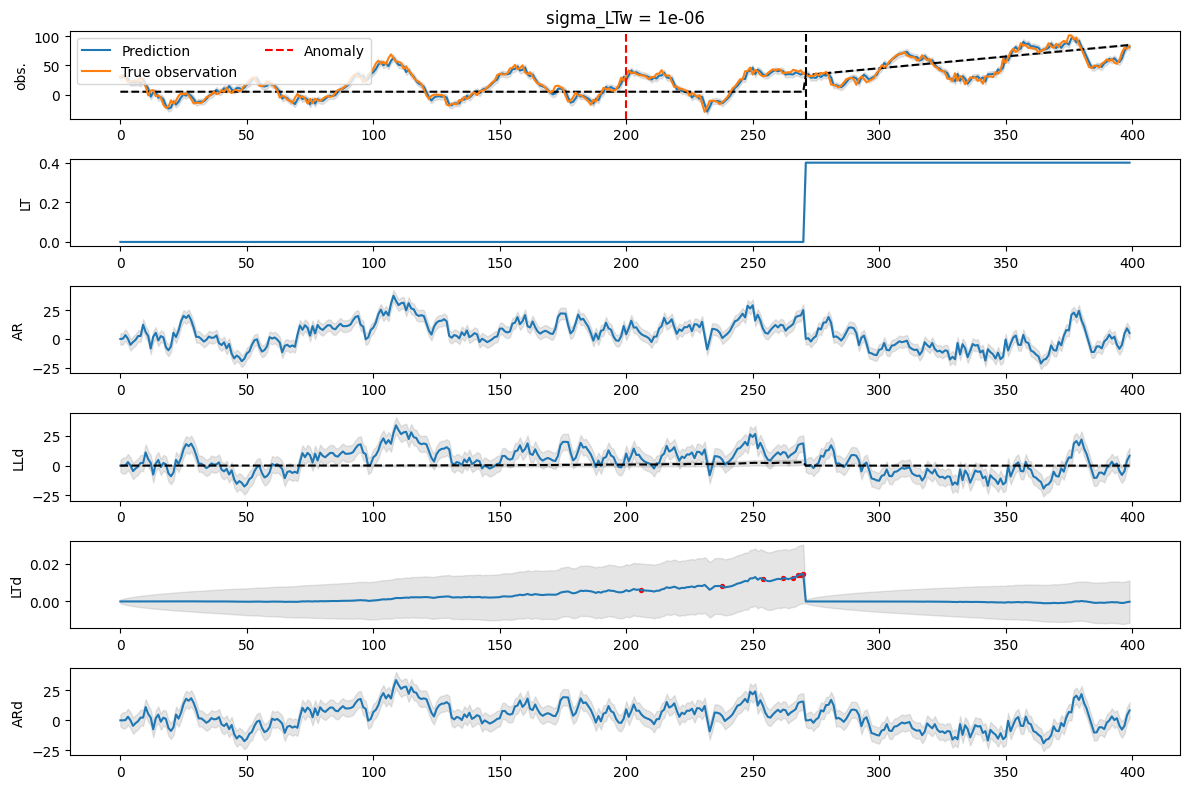

In [10]:
# Plot critic model
plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(6, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])
ax4 = plt.subplot(gs[4])
ax5 = plt.subplot(gs[5])

############ Base model ############
ax0.plot(data['timesteps'][0], yj_pred_mus, label='Prediction')
ax0.fill_between(data['timesteps'][0], np.array(yj_pred_mus)-np.sqrt(yj_pred_vars), np.array(yj_pred_mus)+np.sqrt(yj_pred_vars),color='gray', alpha=0.2)
ax0.plot(data['timesteps'][0], LLj_mu, 'k--')
ax0.fill_between(data['timesteps'][0], np.array(LLj_mu)-np.sqrt(LLj_var), np.array(LLj_mu)+np.sqrt(LLj_var),color='gray', alpha=0.2)
ax0.plot(data['timesteps'][0], data['y'][ts_n], label='True observation')
if data['anm_mag'][0] != 0:
    ax0.axvline(x=data['anm_pos'][0], color='r', linestyle='--', label='Anomaly')
if len(trigger_pos) > 0:
    for trigger in trigger_pos:
        ax0.axvline(x=trigger, color='k', linestyle='--')
ax0.legend(loc='upper left', ncol = 2)
ax0.set_ylabel('obs.')
ax0.set_title('sigma_LTw = ' + str(baseline_process_error_var_all[plot_model_index]))

ax1.plot(data['timesteps'][0], LTj_mu, label='Prediction')
ax1.fill_between(data['timesteps'][0], np.array(LTj_mu)-np.sqrt(LTj_var), np.array(LTj_mu)+np.sqrt(LTj_var),color='gray', alpha=0.2)
ax1.set_ylabel('LT')

ax2.plot(data['timesteps'][0], ARj_mu, label='Prediction')
ax2.fill_between(data['timesteps'][0], np.array(ARj_mu)-np.sqrt(ARj_var), np.array(ARj_mu)+np.sqrt(ARj_var),color='gray', alpha=0.2)
ax2.set_ylabel('AR')

############ Critic model ############
ax3.plot(data['timesteps'][0], yjd_pred_mus, label='Prediction')
ax3.fill_between(data['timesteps'][0], np.array(yjd_pred_mus)-np.sqrt(yjd_pred_vars), np.array(yjd_pred_mus)+np.sqrt(yjd_pred_vars),color='gray', alpha=0.2)
ax3.plot(data['timesteps'][0], LLjd_mu, 'k--')
ax3.fill_between(data['timesteps'][0], np.array(LLjd_mu)-np.sqrt(LLjd_var), np.array(LLjd_mu)+np.sqrt(LLjd_var),color='gray', alpha=0.2)
ax3.set_ylabel('LLd')

ax4.plot(data['timesteps'][0], LTjd_mu, label='Prediction')
ax4.fill_between(data['timesteps'][0], np.array(LTjd_mu)-np.sqrt(LTjd_var), np.array(LTjd_mu)+np.sqrt(LTjd_var),color='gray', alpha=0.2)
ax4.scatter(look_back_idx_list, ltd_history_sample, 8, color='r', label='LTd history')
ax4.set_ylabel('LTd')

ax5.plot(data['timesteps'][0], ARjd_mu, label='Prediction')
ax5.fill_between(data['timesteps'][0], np.array(ARjd_mu)-np.sqrt(ARjd_var), np.array(ARjd_mu)+np.sqrt(ARjd_var),color='gray', alpha=0.2)
ax5.set_ylabel('ARd')


In [11]:
print(len(samples['LTd_history']))
print(len(samples['itv_LT']))
print(len(samples['itv_LL']))
print(len(samples['anm_develop_time']))
print(samples['anm_develop_time'])

71
71
71
71
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
